In [1]:
import requests
from sodapy import Socrata
import pandas as pd
import plotly.plotly as py
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define the API call as the CFPB Consumer Complaints Database
cfpb_dataset = 'data.consumerfinance.gov'

# CSV file for ACS 2017 Median Household Income statistics
census_dataset = 'acs_income_dataset.csv'

In [3]:
# initialize an empty list which will be used to hold the dataframes
dfs = []

# open the file which stores the CCDB API key
f = open("ccdb_api.key", "r")

# store the API key value in a variable
api_key = f.readline()

In [4]:
def batch_retrieve(api_call):
    
    client = Socrata(api_call, api_key)
    
    i = 0
    for df in dfs:
        i += len(df)
    
    results = client.get("s6ew-h6mp", offset = i, limit=100)
    
    results_df = pd.DataFrame.from_records(results)
    
    dfs.append(results_df)

def retrieve_and_concatenate(num_dfs,filename): # this function will retrieve and concat
        
    for i in range(num_dfs):
        
        batch_retrieve(cfpb_dataset)
    
    df = pd.concat(dfs, sort=True)
    
    df.to_pickle(filename)

In [23]:
retrieve_and_concatenate(1000,"state_complaints.csv")

In [7]:
def transform_dataframe(source_dataset):
    
    df = pd.read_pickle(source_dataset)
    
    states = df[(df.state.notnull())]

    companies_groupby = dict(states.groupby(['state'])['company'].apply(list))
    products_groupby = dict(states.groupby(['state'])['product'].apply(list))
    issues_groupby = dict(states.groupby(['state'])['issue'].apply(list))
            
    for k, v in companies_groupby.items():
        c = Counter(v)
        companies_groupby[k] = c.most_common(1)
        
    for k, v in products_groupby.items():
        c = Counter(v)
        products_groupby[k] = c.most_common(1)
        
    for k, v in issues_groupby.items():
        c = Counter(v)
        issues_groupby[k] = c.most_common(1)
            
    companies_data = [[key, v[0], v[1]] for key, value in companies_groupby.items() for v in value]
    products_data = [[key, v[0], v[1]] for key, value in products_groupby.items() for v in value]
    issues_data = [[key, v[0], v[1]] for key, value in issues_groupby.items() for v in value]
    
    companies_df = pd.DataFrame(companies_data, columns=['state', 'company', 'num_of_complaints'])
    companies_df.to_pickle("top_company_complaints_per_state.csv")
    
    products_df = pd.DataFrame(products_data, columns=['state', 'product', 'num_of_complaints'])
    products_df.to_pickle("top_product_complaints_per_state.csv") 
    
    issues_df = pd.DataFrame(issues_data, columns=['state', 'issue', 'num_of_complaints'])
    issues_df.to_pickle("top_issue_complaints_per_state.csv")

In [8]:
transform_dataframe('state_complaints.csv')

In [179]:
def pickle_file(csv_file):
    
    df = pd.read_csv(csv_file,low_memory=False)
    df = df[['GEO.display-label','HC03_EST_VC02']]
    df = df.iloc[1:]
    df.columns = ["zip_code", "med_household_income_17"]
    
    zip_codes = [row.split()[1] for row in df['zip_code']]
    df['zip_code'] = zip_codes
    
    df.to_pickle("zipcodes.csv")

In [214]:
pickle_file(census_dataset)

In [9]:
def join_data(dataset1,dataset2):
    
    ds1_df = pd.read_pickle(dataset1)
    ds1_df = ds1_df[(ds1_df.zip_code.notnull())]
    
    ds2_df = pd.read_pickle(dataset2)
        
    complaints_by_zipcode = pd.merge(ds1_df, ds2_df, on='zip_code')
        
    complaints_by_zipcode.to_pickle("complaints_by_zipcode.csv")

In [24]:
join_data('state_complaints.csv','zipcodes.csv')

In [11]:
def query_complaint_data(dataset):
    
    df = pd.read_pickle(dataset)
        
    median_income_by_zip = df[['state', 'zip_code', 'med_household_income_17']].drop_duplicates()
    
    median_income_by_zip.to_pickle("median_income_by_zip.csv")

In [25]:
query_complaint_data("median_income_by_zip.csv")

In [14]:
def complaints_ordered(source_dataset, metric, limit):
    
    df = pd.read_pickle(source_dataset)

    dictionary = {}
    
    c = Counter(list(df[metric]))
    
    most_common = c.most_common(limit)
    
    for element in most_common:
        dictionary[element[0]] = element[1]
        
    y = list(dictionary.values())
    labels = list(dictionary.keys())
    x = np.arange(len(y))
    
    plt.figure(figsize=(20,6))
    plt.bar(x,y)
    plt.title('Complaints by {}'.format(metric))
    plt.ylabel('Number of complaints')
    plt.xlabel('{}'.format(metric))
    plt.xticks(x,labels)

    plt.show()

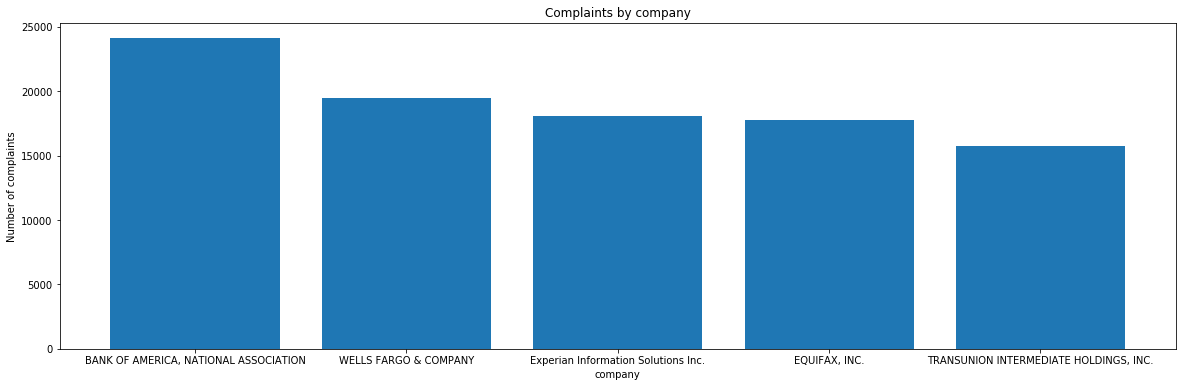

In [15]:
complaints_ordered('state_complaints.csv','company',5)

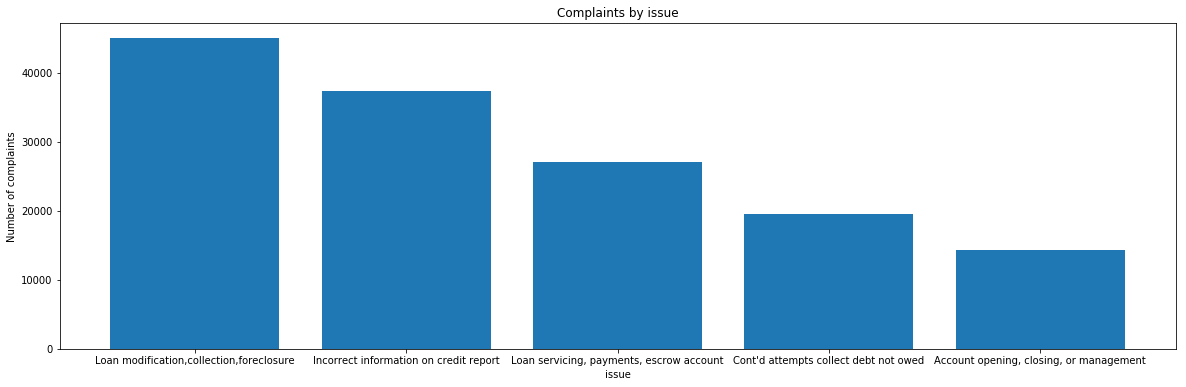

In [277]:
complaints_ordered('state_complaints.csv','issue',5)

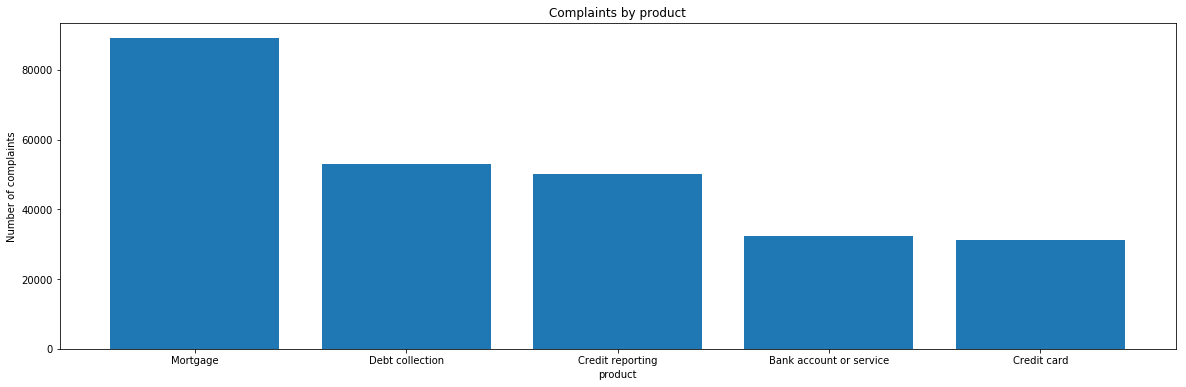

In [281]:
complaints_ordered('state_complaints.csv','product',5)

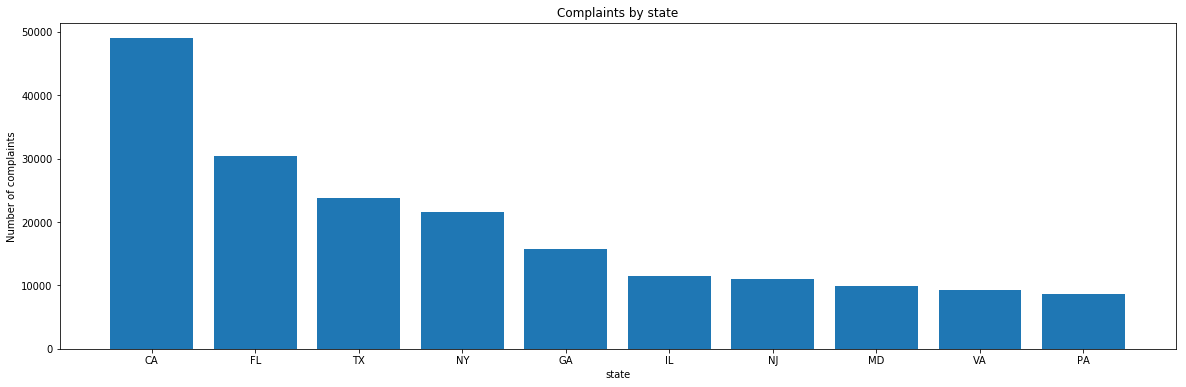

In [282]:
complaints_ordered('state_complaints.csv','state',10)

In [ ]:
complaints_ordered('state_complaints.csv','sub_issue',10)

In [16]:
def state_pop_stats():
    
    state_codes = {
    'WA': 'Washington', 'DE': 'Delaware', 'DC': 'District of Columbia', 
    'WI': 'Wisconsin', 'WV': 'West Virginia', 'HI': 'Hawaii',
    'FL': 'Florida', 'WY': 'Wyoming', 'PR': 'Puerto Rico', 'NJ': 'New Jersey', 
    'NM': 'New Mexico', 'TX': 'Texas','LA': 'Louisiana', 'NC': 'North Carolina', 
    'ND': 'North Dakota', 'NE': 'Nebraska', 'TN': 'Tennessee', 'NY': 'New York',
    'PA': 'Pennsylvania', 'AK': 'Alaska', 'NV': 'Nevada', 'NH': 'New Hampshire', 
    'VA': 'Virginia', 'CO': 'Colorado','CA': 'California', 'AL': 'Alabama', 
    'AR': 'Arkansas', 'VT': 'Vermont', 'IL': 'Illinois', 'GA': 'Georgia',
    'IN': 'Indiana', 'IA': 'Iowa', 'MA': 'Massachusetts', 'AZ': 'Arizona', 
    'ID': 'Idaho', 'CT': 'Connecticut','ME': 'Maine', 'MD': 'Maryland', 
    'OK': 'Oklahoma', 'OH': 'Ohio', 'UT': 'Utah', 'MO': 'Missouri',
    'MN': 'Minnesota', 'MI': 'Michigan', 'RI': 'Rhode Island', 'KS': 'Kansas', 
    'MT': 'Montana', 'MS': 'Mississippi','SC': 'South Carolina', 'KY': 'Kentucky', 
    'OR': 'Oregon', 'SD': 'South Dakota'
    }

    df = pd.read_html("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population", attrs={"class": "wikitable"})
    df = df[0]
    state_populations = df[[2, 3]][1:]
    state_populations.columns = ['state_name','population_16']
    state_populations['population_16'] = state_populations['population_16'].astype(np.int64)
        
    states = pd.DataFrame.from_dict(state_codes, orient='index')
    states.index.name = 'state'
    states.columns = ['state_name']
    states = states.reset_index()
    states_by_population = pd.merge(states, state_populations, on='state_name')
    states_by_population.to_pickle('states_by_population.csv')

In [17]:
state_pop_stats()

In [18]:
def complaints_per_pop(source_dataset):

    df1 = pd.read_pickle(source_dataset)
    df2 = pd.read_pickle('states_by_population.csv')
    
    df3 = pd.merge(df1, df2, on='state')
    df3['per_pop'] = df3['num_of_complaints'] / df3 ['population_16']
    df3.to_pickle(source_dataset)

In [19]:
complaints_per_pop("top_company_complaints_per_state.csv")
complaints_per_pop("top_product_complaints_per_state.csv")
complaints_per_pop("top_issue_complaints_per_state.csv")

In [27]:
def visualization(filename,grouped_data,metric):
    
    df = pd.read_pickle(filename)
    
    for col in df.columns:
        df[col] = df[col].astype(str)

    scl = [[0.0, 'rgb(242,246,249)'],[0.2, 'rgb(212,230,243)'],[0.4, 'rgb(179,213,239)'],\
            [0.6, 'rgb(166,205,239)'],[0.8, 'rgb(157,202,236)'],[1.0, 'rgb(92,150,208)']]

    df['text'] = df['state'] + '<br>' +\
    df[grouped_data] + ' has ' + df['num_of_complaints'] + ' complaints.'

    data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['state'],
        z = df[metric].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of complaints")
        ) ]

    layout = dict(
        title = '2018 CFPB Statistics: Most complained about companies, products and issues',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
    fig = dict( data=data, layout=layout )
    visualization = py.iplot( fig, filename='d3-cloropleth-map' )
    
    return visualization

In [28]:
visualization("top_company_complaints_per_state.csv",'company','per_pop')

In [22]:
visualization("top_company_complaints_per_state.csv",'company','num_of_complaints')

In [234]:
visualization("top_product_complaints_per_state.csv",'product','per_pop')

In [235]:
visualization("top_product_complaints_per_state.csv",'product','num_of_complaints')

In [236]:
visualization("top_issue_complaints_per_state.csv",'issue','per_pop')

In [237]:
visualization("top_issue_complaints_per_state.csv",'issue','num_of_complaints')